In this notebook, we will directly look at the implementation of the familiar dataset `MNIST Fashion Dataset` using CNN architecture and the PyTorch Framework.

In [1]:
!pip install torchmetrics
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Import necessary libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

### Load the dataset:

In [3]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:00<00:00, 39550297.51it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5438903.50it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 38156645.46it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21766408.26it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



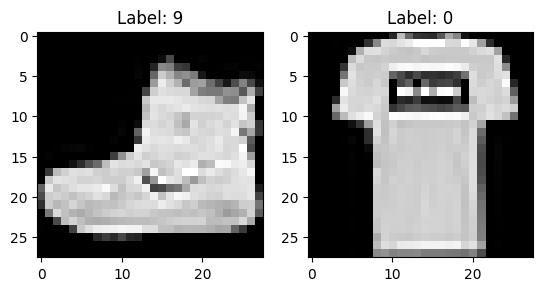

In [31]:
import matplotlib.pyplot as plt

image1, label1 = train_data[0]
image2, label2 = train_data[1]

plt.subplot(1,2,1)
plt.title(f'Label: {label1}')
plt.imshow(image1.squeeze(), cmap='gray')           # Convert the image to a NumPy array and plot it

plt.subplot(1,2,2)
plt.title(f'Label: {label2}')
plt.imshow(image2.squeeze(), cmap='gray')


Lets check the number of classes, which we will need to specify the `num_classes` later.

In [4]:
classes = train_data.classes
num_classes = len(train_data.classes)

print(num_classes)

10


In [23]:
num_input_channels = 1
num_output_channels = 16
image_size = train_data[0][0].shape[1]

print(image_size)

28


Lets create a dataloader for the training set.

In [6]:
dataloader_train = DataLoader(train_data, batch_size = 8, shuffle = True)

In [7]:
image, labels = next(iter(dataloader_train))
#print(image.squeeze().permute(1,2,0))
print(image.shape)

torch.Size([8, 1, 28, 28])


In [8]:
count = 0
for img, labels in dataloader_train:
    count += 1
print(count)
print(labels.unique)

7500
<bound method Tensor.unique of tensor([6, 2, 3, 1, 2, 1, 8, 1])>


### Architecture defintion:

In [9]:
class Net(nn.Module):

    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.fc = nn.Linear(num_output_channels * (image_size//2)**2, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [56]:
pip install torchviz


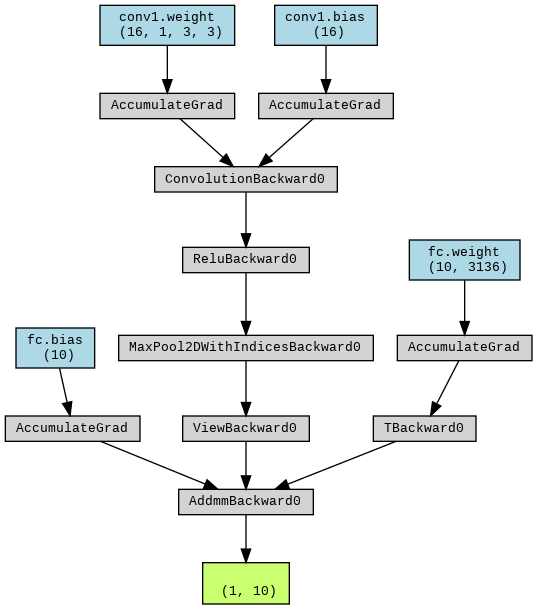

In [58]:
num_classes = 10                                         # For FashionMNIST dataset
model = Net(num_classes)                                 # Instantiate the model


sample_input = torch.randn(1, 1, 28, 28)                 # Just a sample input: Batch size of 1, 1 input channel, 28x28 image

output = model(sample_input)                             # forward pass to generate the computation graph


dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')


from IPython.display import Image
Image('model_architecture.png')

Lets chooaw ADAM as our optimizer. The learning rate of 0.001 is specified in the parameter.

In [59]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Training Loop:

In [11]:
def train_model(optimizer, net, num_epochs):
    num_processed = 0
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0
        for features, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)

        print(f'epoch {epoch}, loss: {running_loss / num_processed}')

    train_loss = running_loss / len(dataloader_train)


Lets call the function.

In [13]:
train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=5,
)

epoch 0, loss: 0.03190180098302371
epoch 1, loss: 0.029325494236439046
epoch 2, loss: 0.027434061053268184
epoch 3, loss: 0.025924030154435042
epoch 4, loss: 0.024698835190622534


Similarly dataloader for test instances is made below:

In [14]:
dataloader_test = DataLoader(test_data, batch_size = 8, shuffle = False)

Definition of various evaluation metric, with the number of classes specified in the parameter:

In [15]:
acc = Accuracy(task='multiclass', num_classes=num_classes)
prec = Precision(task='multiclass', num_classes=num_classes, average=None)
rec = Recall(task='multiclass', num_classes=num_classes, average=None)

### Evaluation Loop:

In [16]:
net.eval()
predictions = []

for i, (features, labels) in enumerate(dataloader_test):
    output = net.forward(features.reshape(-1, 1, image_size, image_size))
    cat = torch.argmax(output, dim=-1)
    predictions.extend(cat.tolist())
    acc(cat, labels)
    prec(cat, labels)
    rec(cat, labels)


accuracy = acc.compute().item()
precision = prec.compute().tolist()
recall = rec.compute().tolist()


print('Accuracy:', accuracy)
print('Precision (per class):', precision)
print('Recall (per class):', recall)

Accuracy: 0.8934000134468079
Precision (per class): [0.8084914088249207, 0.9869999885559082, 0.7147262692451477, 0.9365591406822205, 0.8617977499961853, 0.9828282594680786, 0.7811704874038696, 0.9582919478416443, 0.9826883673667908, 0.9594460725784302]
Recall (per class): [0.8949999809265137, 0.9869999885559082, 0.9269999861717224, 0.8709999918937683, 0.7670000195503235, 0.9729999899864197, 0.6140000224113464, 0.9649999737739563, 0.9649999737739563, 0.9700000286102295]


As we cab see, the model after being trained for 5 epochs gave a pretty good accuracy in classifying the clothes. The precision and recall values can be seen  as a list.

Lets test on a random instance. lets pick the very first instance from the test_set.

In [40]:
test_image1, test_label1 = test_data[0]

test_image1 = test_image1.unsqueeze(0)  # Add batch dimension

pred = net(test_image1)
print(pred)
print(torch.argmax(pred))

tensor([[-12.0497, -19.2666, -11.7207, -18.6040, -12.9123,  -4.5240, -11.1707,
          -3.9157,  -8.5397,   4.3344]], grad_fn=<AddmmBackward0>)
tensor(9)


Lets plot the image and check if the model `net` predicted it correctly or not.

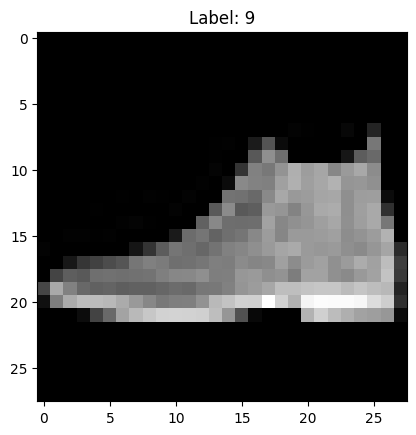

In [42]:
plt.title(f'Label: {test_label1}')
plt.imshow(test_image1.squeeze(), cmap='gray')

The prediction was correct.